# Generalized Bass Model

Generalized Bass model allows to estimate how marketing mix variables (e.g., price, ad spending) affect product diffussion.
$$\hat{A}(t) = M\cdot\frac{1-exp(-(p+q)t^*)}{1+\frac{q}{p}exp(-(p+q)t^*)}$$ <br>
where $t^* = t + b1\cdot ln(\frac{price(t)}{price(1)}) + p2\cdot ln(\frac{adv(t)}{adv(1)}) $ is the **effective diffussion time**.

$$\hat{N}(t) = \hat{A}(t)-\hat{A}(t-1)$$ <br>

The only difference between GBM and vanilla BM is that GBM adjusts time to **"effective time"**, which accounts for the impact of marketing mixes. GBM also has two more parameters: price impact $b1$ and advertising impact $b2$. You need to have marketing mix data to use GBM, and it's ok to include only price or only advertising.

## Estimate GBM

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import least_squares                 # package to conduct Nonlinear least square 

# import historical data 
url = "https://raw.githubusercontent.com/zoutianxin1992/MarketingAnalyticsPython/main/Marketing%20Analytics%20in%20Python/Bass%20model/Dataset/3-3%20GBM%20floppy%20disk.csv"
df = pd.read_csv(url) 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    12 non-null     int64  
 1   time    12 non-null     int64  
 2   Sales   12 non-null     int64  
 3   Price   12 non-null     float64
dtypes: float64(1), int64(3)
memory usage: 512.0 bytes


In [2]:
# Rename the variables to t, N, and Price
df.rename(columns = {df.columns[1]:"t",df.columns[2]:"N",df.columns[3]:"Price"}, inplace = True)  # "inplace" apply the name change to df itself 
df.head()

,Year,t,N,Price
0,1987,1,315,869.84
1,1988,2,365,706.85
2,1989,3,426,697.18
3,1990,4,489,642.13
4,1991,5,530,581.13


In [3]:
# define A_hat(t) and N_hat(t)
# Remember GBM has an additional variable (Price) and an additional parameter (b1)
Price_1 = df['Price'][0]
def A_hat(t,Price,p,q,M,b1):                                     # two more arguments: Price and b1
    tstar = t + b1 * np.log(Price/Price_1)                        #tstar: effective time
    return M * (1 - np.exp(-(p+q)*tstar))/(1 + q / p* np.exp(-(p+q)*tstar))    # the "t" in BM is replaced with "t*" in GBM

# define N_hat(t) 
def N_hat(t,Price,p,q,M,b1):  
    return A_hat(t,Price,p,q,M,b1) - A_hat(t-1,Price,p,q,M,b1)  # We can use the A_hat function instead of manually typing the formula

In [4]:
# define prediction errors as a fucntion of p,q,M, and b1
T = len(df['N'])   # number of periods for historical data


def prediction_error(params):   # Note that we input p,q,M,b1 as a 1*4 array "params."  
    p = params[0]
    q = params[1]
    M = params[2]
    b1 = params[3]
    Nhat = [N_hat(t,df['Price'][t-1],p,q,M,b1) for t in range(1,T+1)]            # Given p,q,M, generate Bass prediction for each period
    return df['N'] - Nhat                                 # Prediction error for each period

The initial guesses for $p ,q , M$ are the same for BM. The initial guesses are better to be set at -0.3 for $b1$ and 0.3 for $b2$.

In [5]:
# estimate p,q,M,b1 using least_squares
# Bass model requires 0<p<1, 0<q<1, M>0, and b1<0 so we need to add the constraints
A_t = sum(df['N'])           # calculate already adopters until period t
params0 = [0.01,0.16,3*A_t,-0.3]  # initial guess for p,q,M, b1. Required by least_squares
estim_results= least_squares(prediction_error, params0, bounds = ([0,0,0,-np.Inf],[np.Inf,np.Inf,np.Inf,0]) )
estim_results
#########################
# prediction_error: an array of prediction errors for each period
# param0: initial guesses
# bounds: The bounds for p,q,M, and b1. In our case p,q,M>0 and b1<0

 active_mask: array([0, 0, 0, 0])
        cost: 3098.774541714975
         fun: array([ 18.81654458,  -3.00418784,   6.80748769,   9.08856308,
        -9.62535932, -29.3701144 , -16.44843228, -14.52910416,
        34.54675556,  40.59721649,   4.66195867, -37.48699244])
        grad: array([ 1.06558110e+01,  1.25987685e+00, -1.78232529e-06, -1.72308813e-02])
         jac: array([[-1.21933296e+04, -1.49072342e+02, -2.58349272e-02,
        -0.00000000e+00],
       [-1.42966146e+04, -7.10875179e+02, -3.20995684e-02,
         1.00615006e+01],
       [-1.53932378e+04, -1.16322467e+03, -3.65645274e-02,
         1.10594910e+01],
       [-1.61112167e+04, -1.73459448e+03, -4.18608043e-02,
         1.49169071e+01],
       [-1.59345334e+04, -2.30446141e+03, -4.70694118e-02,
         1.79754015e+01],
       [-1.49741794e+04, -2.67811392e+03, -5.07106435e-02,
         1.53952989e+01],
       [-1.32167885e+04, -2.92829321e+03, -5.36831667e-02,
         1.18136984e+01],
       [-1.06227268e+04, -3.006

In [6]:
#store estimated parameters
p_estim = estim_results.x[0]
q_estim = estim_results.x[1]
M_estim = estim_results.x[2]
b1_estim = estim_results.x[3]

## Predict future sales for the next three periods

We will predict the sales for period 13-15, assuming the prices will be 350, 325, and 300.

In [7]:
# Appending the future prices to the historical price data
Price_15 = df["Price"].append(pd.Series([350,325,300]))
T_pred = 15  # number of periods for prediction
predictA = [A_hat(t,Price_15.iat[t-1],p_estim,q_estim,M_estim,b1_estim) for t in range(1,T_pred+1)]  # predict already adopters for T periods
predictN = [N_hat(t,Price_15.iat[t-1],p_estim,q_estim,M_estim,b1_estim) for t in range(1,T_pred+1)]  # predict already adopters for T periods


Text(0.5, 0, 'time')

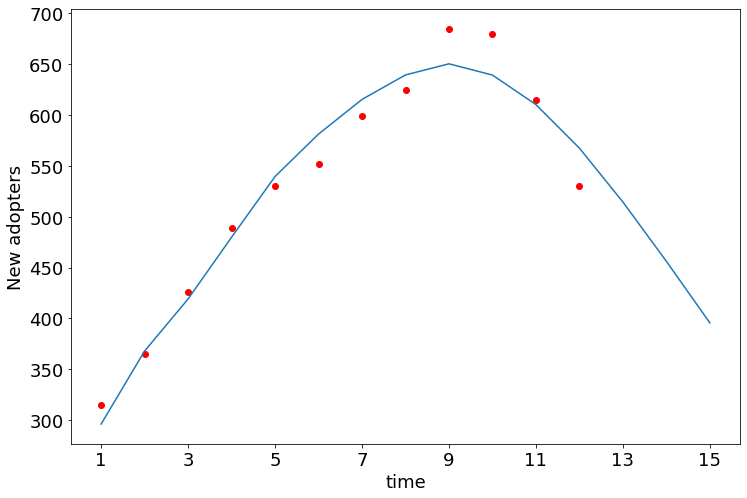

In [8]:
# Plot the trajectory of new adopters

plt.rcParams['figure.figsize'] = [12,8]  # set figure size to be 12*8 inch
plt.plot(range(1,T_pred+1),predictN)
plt.scatter(range(1,T+1),df["N"],color = "red")    # Also plot historical sales data
plt.xticks(range(1,T_pred+1,2), fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel("New adopters",fontsize = 18)
plt.xlabel("time", fontsize = 18)